# A graphene ribbon simulation using LAMMPS with machine learning interatomic potentials from DeePMD-kit

Manh-Thuong Nguyen, Tuoc Vu, Phong Pham, & Huan Tran

This notebook is mostly based on the work by Liang *et al.*, ‘‘[Learning DeePMD-kit: A guide to building deep potential models](https://doi.org/10.1063/9780735425279_006),’’ in ‘‘A Practical Guide to Recent Advances in Multiscale Modeling and Simulation of Biomolecules’’, edited by Y. Wang and R. Zhou (AIP Publishing, Melville, New York, 2023), pp. 6-1–6-20. You are invited to have a look at their work and references therein for a better understanding of the method. More information can be found at https://docs.deepmodeling.org/.

The idea of the present tutorial is to get you started with using available tools to do practical atomistic modeling problems. Our goal is two-fold: (1) train machine learning interatomic potentials (MLIPs) using DeePMD-kit for a graphene ribbon study, on ab initio molecular dynamics (AIMD) potential energy surfaces, and (2) use that potentials to run MLIP-based molecular dynamics (MD) simulations on a larger system. Note that the AIMD simulation for reference data has been readied, by M.-T. Nguyen, using VASP for this particular material, from one of his projects. The MD simulations is then facilitated with the help of the popular LAMMPS engine.


We need the following packages:

1. DeepMD: to train MLIPs.
2. dpdata: for data manpipulation.
3. LAMMPS: a popular MD engine, running with our MLIPs.
4. Ovito: for visualization.

Notes:

1. Training time is about 25 minutes on cloud servers.
2. This tutorial also comes with a version running on Linux cluster, all packed in VietMI24 directory.


# Install condacolab

# Mục mới

In [1]:
# installation
!pip install -q condacolab
import condacolab;
condacolab.install();

✨🍰✨ Everything looks OK!


In [2]:
# checking
!conda --version

conda 24.11.2


# Install deepmd-kit


In [3]:
# installation
!conda create -n deepmd deepmd-kit -c conda-forge
!conda install --channel conda-forge dpdata

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.2
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local/envs/deepmd

  added / updated specs:
    - deepmd-kit


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    absl-py-2.1.0              |     pyhd8ed1ab_1         105 KB  conda-forge
    annotated-types-0.7.0      |     pyhd8ed1ab_1          18 KB  conda-forge
    array-api-compat-1.11.1    |     pyh29332c3_1          41 KB  conda-forge
    astunparse-1.6.3           |     pyhd8ed1ab_3          18 KB  conda-forge
    attr-2.5.1                 |       h166bdaf_1          69 KB  conda-forge
    bracex-2.2.1               |     pyhd8ed1ab_0          14 KB  conda-forge
  

In [4]:
# checking the environment
envs = "source activate base; conda activate deepmd"
!$envs; which dp;

/usr/local/envs/deepmd/bin/dp


# Mount your Google drive

In [5]:
# mount Google Drive where the data are stored.
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [6]:
# Look at VietMI24 folder, you will see the tutorial data
vmi24f = r'/content/drive/MyDrive/Bai_bao'
!ls $vmi24f

data_622  Find_RMSD.ipynb  NMC_622_1023K_3  NMC_622_2000K_3  NMC_811_300K_3
data_811  input.json	   NMC_622_1023K_5  NMC_622_300K_3   Tutorial2_DeePMD_potential.ipynb
data_955  kiem_dinh_cheo   NMC_622_1223K_3  NMC_622_300K_5


# Process the data: from AIMD runs in OUTCAR format

In [7]:
# read the OUTCAR, then split it into the training/validation sets:
import dpdata
import numpy as np
import os


os.chdir(vmi24f+"/NMC_622_1223K/00_data/")
data = dpdata.LabeledSystem('OUTCAR_NMC622_1223K', fmt='vasp/outcar')
print('# the data contains %d frames' % len(data))
NFrames=len(data)
index_validation = np.random.choice(NFrames,size=int(2*NFrames/10),replace= False)
index_training = list(set(range(NFrames))-set(index_validation))
data_training = data.sub_system(index_training)
data_validation = data.sub_system(index_validation)
total_data = data.sub_system(list(range(NFrames)))
total_data.to_deepmd_npy('total_data')
data_training.to_deepmd_npy('training_data')
data_validation.to_deepmd_npy('validation_data')
print ('# the training data contains %d frames' % len(data_training))
print ('# the validation data contains %d frames' % len(data_validation))

/usr/local/lib/python3.11/site-packages/dpdata/vasp/outcar.py:102: UserWarning: The following structures were unconverged: [282]; so they are not collected.
  warnings.warn(


# the data contains 499 frames
# the training data contains 400 frames
# the validation data contains 99 frames


In [23]:
type(index_validation)

numpy.ndarray

In [26]:
type(index_training)

list

In [19]:
type(data)

numpy.ndarray

In [20]:
type(data_training)

dpdata.system.LabeledSystem

In [25]:
type(list(range(NFrames)))

list

In [ ]:
atom_type = data["atom_types"]
print(len(atom_type))

60


In [ ]:
energy = data["energies"]
print(len(energy))

495


In [ ]:
cell = data["cells"]
print(cell)

[[[14.21450043  0.          0.        ]
  [-1.42145002  2.46202365  0.        ]
  [ 0.          0.         14.14560032]]

 [[14.21450043  0.          0.        ]
  [-1.42145002  2.46202365  0.        ]
  [ 0.          0.         14.14560032]]

 [[14.21450043  0.          0.        ]
  [-1.42145002  2.46202365  0.        ]
  [ 0.          0.         14.14560032]]

 ...

 [[14.21450043  0.          0.        ]
  [-1.42145002  2.46202365  0.        ]
  [ 0.          0.         14.14560032]]

 [[14.21450043  0.          0.        ]
  [-1.42145002  2.46202365  0.        ]
  [ 0.          0.         14.14560032]]

 [[14.21450043  0.          0.        ]
  [-1.42145002  2.46202365  0.        ]
  [ 0.          0.         14.14560032]]]


In [ ]:
force = data["forces"]
print(force)

[[[-0.14249  -0.082457 -0.341977]
  [ 0.146541  0.086254 -0.226127]
  [-0.05219  -0.029925  0.156293]
  ...
  [-0.101303 -0.05427   0.545031]
  [-0.053218 -0.011152  0.76829 ]
  [ 0.300772  0.16812  -0.943114]]

 [[-0.157246 -0.091135 -0.428151]
  [ 0.111322  0.065856 -0.246615]
  [-0.063351 -0.036318  0.185851]
  ...
  [-0.111782 -0.051587  0.491366]
  [-0.069137 -0.013011  0.798375]
  [ 0.379052  0.214449 -0.991569]]

 [[-0.178377 -0.103729 -0.5478  ]
  [ 0.088547  0.050353 -0.224901]
  [-0.054262 -0.031021  0.238708]
  ...
  [-0.106329 -0.035169  0.378509]
  [-0.08252  -0.012249  0.739241]
  [ 0.485879  0.276995 -0.931539]]

 ...

 [[-0.111752  1.156914  0.930479]
  [ 0.17681   0.242191  0.41696 ]
  [-1.156067  4.720985 -2.044425]
  ...
  [-1.575369  0.804715 -0.799875]
  [-0.480727 -2.840576 -7.014128]
  [-0.993564  1.973342 -1.764727]]

 [[ 1.017039 -0.175669  1.529983]
  [ 0.074212  0.4739    0.232765]
  [ 2.043321 -1.570965 -2.03841 ]
  ...
  [-2.293151  4.983119 -3.234956]
  [-

In [ ]:
atom_name = data["atom_names"]
print(atom_name)

['Li', 'Ni', 'O', 'Co', 'Mn']


In [ ]:
number_of_atoms = data["atom_numbs"]
print(number_of_atoms)

[np.int64(15), np.int64(9), np.int64(30), np.int64(3), np.int64(3)]


In [ ]:
coordinates = data["coords"]
print(coordinates.shape)

(500, 60, 3)


In [8]:
print(data)

Data Summary
Labeled System
-------------------
Frame Numbers      : 499
Atom Numbers       : 60
Including Virials  : Yes
Element List       :
-------------------
Li  Ni  O  Co  Mn
15  9  30  3  3


# Training the DeepMD potential

In [9]:
# input for training a DeePMD potential.
import json
f = open(vmi24f+"/NMC_622_1223K/01_train/input.json", 'r')
fp = json.load(f)
print (json.dumps(fp, indent=2))

{
  "_comment": "that's all",
  "model": {
    "type_map": [
      "Li",
      "Ni",
      "O",
      "Co",
      "Mn"
    ],
    "descriptor": {
      "type": "se_e2_a",
      "sel": [
        15,
        9,
        30,
        3,
        3
      ],
      "rcut_smth": 0.5,
      "rcut": 6.0,
      "neuron": [
        10,
        20,
        40
      ],
      "resnet_dt": false,
      "axis_neuron": 4,
      "seed": 1,
      "_comment": " that's all"
    },
    "fitting_net": {
      "neuron": [
        100,
        100,
        100
      ],
      "resnet_dt": true,
      "seed": 1,
      "_comment": " that's all"
    },
    "_comment": " that's all"
  },
  "learning_rate": {
    "type": "exp",
    "decay_steps": 1000,
    "start_lr": 0.001,
    "stop_lr": 3.51e-08,
    "_comment": "that's all"
  },
  "loss": {
    "type": "ener",
    "start_pref_e": 0.02,
    "limit_pref_e": 1,
    "start_pref_f": 1000,
    "limit_pref_f": 1,
    "start_pref_v": 0,
    "limit_pref_v": 0,
    "_comment

In [11]:
# Modify the input file

# Reduce the "numb_steps" to 10000
fp['training']['numb_steps'] = 50000

# Print to see the results
print (json.dumps(fp, indent=2))

# Save back to the input file
with open(vmi24f+"/NMC_622_1023K_5/01_train/input.json", 'w') as f:
    json.dump(fp, f, indent=2)

{
  "_comment": "that's all",
  "model": {
    "type_map": [
      "Li",
      "Ni",
      "O",
      "Co",
      "Mn"
    ],
    "descriptor": {
      "type": "se_e2_a",
      "sel": [
        15,
        9,
        30,
        3,
        3
      ],
      "rcut_smth": 0.5,
      "rcut": 6.0,
      "neuron": [
        10,
        20,
        40
      ],
      "resnet_dt": false,
      "axis_neuron": 4,
      "seed": 1,
      "_comment": " that's all"
    },
    "fitting_net": {
      "neuron": [
        100,
        100,
        100
      ],
      "resnet_dt": true,
      "seed": 1,
      "_comment": " that's all"
    },
    "_comment": " that's all"
  },
  "learning_rate": {
    "type": "exp",
    "decay_steps": 1000,
    "start_lr": 0.001,
    "stop_lr": 3.51e-08,
    "_comment": "that's all"
  },
  "loss": {
    "type": "ener",
    "start_pref_e": 0.02,
    "limit_pref_e": 1,
    "start_pref_f": 1000,
    "limit_pref_f": 1,
    "start_pref_v": 0,
    "limit_pref_v": 0,
    "_comment

In [10]:
#training
!cd $vmi24f/NMC_622_1223K/01_train; $envs; \
dp train input.json

2025-03-20 14:19:53.290394: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
To get the best performance, it is recommended to adjust the number of threads by setting the environment variables OMP_NUM_THREADS, DP_INTRA_OP_PARALLELISM_THREADS, and DP_INTER_OP_PARALLELISM_THREADS. See https://deepmd.rtfd.io/parallelism/ for more information.
Switch to serial execution due to lack of horovod module.
[2025-03-20 14:20:00,607] DEEPMD INFO    Calculate neighbor statistics... (add --skip-neighbor-stat to skip this step)
[2025-03-20 14:20:00,708] DEEPMD WARNING You can use the environment variable DP_INFER_BATCH_SIZE tocontrol the inference batch size (nframes * natoms). The default value is 1024.
I0000 00:00:1742480400.944849    3825 mlir_graph

In [11]:
# freezing and compressing
!cd $vmi24f/NMC_622_1223K/01_train/; $envs; \
dp freeze -o graph.pb;

2025-03-20 14:59:28.351023: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
To get the best performance, it is recommended to adjust the number of threads by setting the environment variables OMP_NUM_THREADS, DP_INTRA_OP_PARALLELISM_THREADS, and DP_INTER_OP_PARALLELISM_THREADS. See https://deepmd.rtfd.io/parallelism/ for more information.
I0000 00:00:1742482780.844931   14285 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
[2025-03-20 14:59:42,054] DEEPMD INFO    The following nodes will be frozen: ['model_attr/tmap', 'model_attr/model_version', 'train_attr/min_nbor_dist', 'descrpt_attr/rcut', 'o_atom_virial', 'o_virial', 'o_force', 'train_attr/training_script', 'model_attr/model_type', 'descrpt_attr/ntypes

In [12]:
!cd $vmi24f//NMC_622_1223K/01_train/; $envs; \
dp compress -i graph.pb -o graph-compress.pb

2025-03-20 15:01:23.074843: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
To get the best performance, it is recommended to adjust the number of threads by setting the environment variables OMP_NUM_THREADS, DP_INTRA_OP_PARALLELISM_THREADS, and DP_INTER_OP_PARALLELISM_THREADS. See https://deepmd.rtfd.io/parallelism/ for more information.
I0000 00:00:1742482888.047300   14771 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
[2025-03-20 15:01:28,686] DEEPMD INFO    


[2025-03-20 15:01:28,687] DEEPMD INFO    stage 1: compress the model
[2025-03-20 15:01:28,696] DEEPMD WARNING Switch to serial execution due to lack of horovod module.
[2025-03-20 15:01:28,774] DEEPMD INFO     _____               _____   __  __ 

In [13]:
# testing
!cd $vmi24f/NMC_622_1223K/01_train/; $envs; \
dp test -m graph-compress.pb -s ../00_data/validation_data -n 99 -d tests
#dp test -m graph-compress.pb -s ../00_data/validation_data -n 10 -d tests

[2025-03-20 15:02:27,887] DEEPMD WARNING To get the best performance, it is recommended to adjust the number of threads by setting the environment variables OMP_NUM_THREADS, DP_INTRA_OP_PARALLELISM_THREADS, and DP_INTER_OP_PARALLELISM_THREADS. See https://deepmd.rtfd.io/parallelism/ for more information.
I0000 00:00:1742482948.869406   15035 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled
[2025-03-20 15:02:29,801] DEEPMD WARNING You can use the environment variable DP_INFER_BATCH_SIZE tocontrol the inference batch size (nframes * natoms). The default value is 1024.
[2025-03-20 15:02:29,929] DEEPMD INFO    # ---------------output of dp test--------------- 
[2025-03-20 15:02:29,929] DEEPMD INFO    # testing system : ../00_data/validation_data
[2025-03-20 15:02:33,580] DEEPMD INFO    # number of test data : 99 
[2025-03-20 15:02:33,581] DEEPMD INFO    Energy MAE         : 4.548691e-01 eV
[2025-03-20 15:02:33,581] DEEPMD INFO    Energy RMSE        : 5.665883e-

In [ ]:
# other packages for data visualization
!conda install ipykernel
#!conda install matplotlib
#!python3 -m venv sklearn-env
#!source sklearn-env/bin/activate
#!pip install -U scikit-learn

Channels:
 - conda-forge
Platform: linux-64
Solving environment: - \ | / done


==> WARNING: A newer version of conda exists. <==
    current version: 24.11.3
    latest version: 25.1.1

Please update conda by running

    $ conda update -n base -c conda-forge conda



## Package Plan ##

  environment location: /usr/local

  added / updated specs:
    - ipykernel


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    asttokens-3.0.0            |     pyhd8ed1ab_1          28 KB  conda-forge
    comm-0.2.2                 |     pyhd8ed1ab_1          12 KB  conda-forge
    debugpy-1.8.13             |  py311hfdbb021_0         2.4 MB  conda-forge
    decorator-5.2.1            |     pyhd8ed1ab_0          14 KB  conda-forge
    exceptiongroup-1.2.2       |     pyhd8ed1ab_1          20 KB  conda-forge
    executing-2.1.0            |     pyhd8ed1ab_1          28 KB  conda-forge
    ipykern

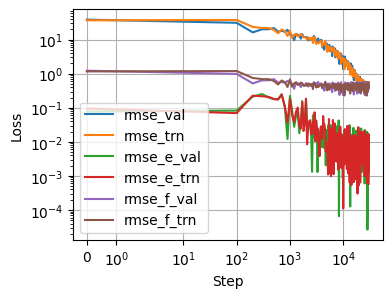

In [14]:
# show the learning curve: for loss/error functions
import numpy as np
import matplotlib.pyplot as plt
import os

os.chdir(vmi24f+"/NMC_622_1223K/01_train/")
data = np.genfromtxt("lcurve.out", names=True)
plt.figure(figsize=(4,3))

for name in data.dtype.names[1:-1]:
    plt.plot(data["step"], data[name], label=name)
plt.legend()
plt.xlabel("Step")
plt.ylabel("Loss")
plt.xscale("symlog")
plt.yscale("log")
plt.grid()
plt.savefig('lcurve.png')

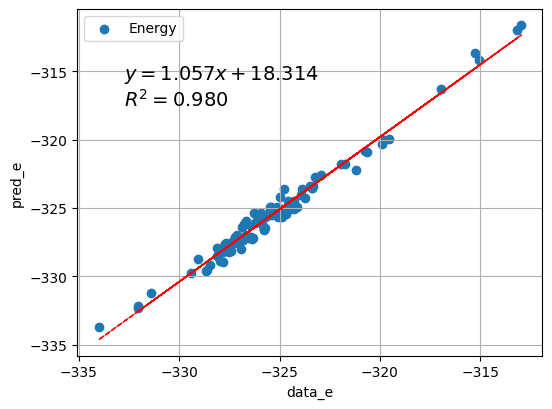

In [15]:
# and for the prediction/data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

os.chdir(vmi24f+"/NMC_622_1223K/01_train/")
data = np.genfromtxt("tests.e.out", skip_header=1)
plt.figure(figsize=(6,4.5))

x = data[:,1]; y = data[:,0]
plt.scatter(x, y, label="Energy"); plt.legend()
plt.xlabel("data_e"); plt.ylabel("pred_e"); plt.grid()

z = np.polyfit(x, y, 1)
yf = np.poly1d(z)(x)
plt.plot(x, yf, 'r--', lw=1)

text = f"$y={z[0]:0.3f} x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,yf):0.3f}$"
plt.gca().text(0.10, 0.72, text, transform=plt.gca().transAxes, fontsize=14)
plt.savefig('tests.e.png'); #plt.clf()

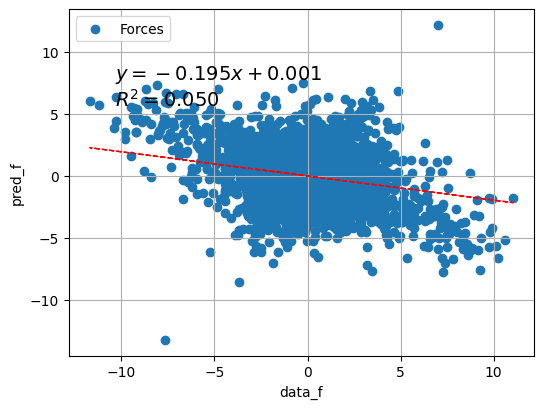

In [ ]:
os.chdir(vmi24f+"/Dp-tutorial/01_train/")
data = np.genfromtxt("tests.f.out", skip_header=1)
plt.figure(figsize=(6,4.5))

x = data[:,1]; y = data[:,0]
plt.scatter(x, y, label="Forces"); plt.legend()
plt.xlabel("data_f"); plt.ylabel("pred_f"); plt.grid()

z = np.polyfit(x, y, 1)
yf = np.poly1d(z)(x)
plt.plot(x, yf, 'r--', lw=1)

text = f"$y={z[0]:0.3f} x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,yf):0.3f}$"
plt.gca().text(0.10, 0.72, text, transform=plt.gca().transAxes, fontsize=14)
plt.savefig('tests.f.png'); #plt.clf()

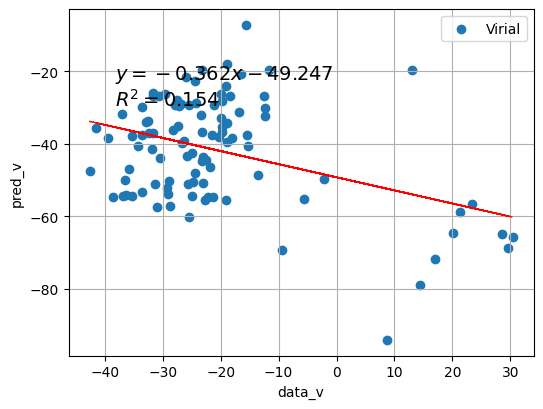

In [ ]:
os.chdir(vmi24f+"/Dp-tutorial/01_train/")
data = np.genfromtxt("tests.v.out", skip_header=1)
plt.figure(figsize=(6,4.5))

x = data[:,1]; y = data[:,0]
plt.scatter(x, y, label="Virial"); plt.legend()
plt.xlabel("data_v"); plt.ylabel("pred_v"); plt.grid()

z = np.polyfit(x, y, 1)
yf = np.poly1d(z)(x)
plt.plot(x, yf, 'r--', lw=1)

text = f"$y={z[0]:0.3f} x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,yf):0.3f}$"
plt.gca().text(0.10, 0.72, text, transform=plt.gca().transAxes, fontsize=14)
plt.savefig('tests.v.png'); #plt.clf()

In [ ]:
# uncomment this cell to show the validation for energy per atom
#data = np.genfromtxt("tests.e_peratom.out", skip_header=1)
#plt.figure(figsize=(4,3))
#x = range(len(data[:,0])); y = data[:,1] - data[:,0]
#plt.scatter(x, y, label="validation (eV/atom)"); plt.legend()
#plt.xlabel("data"); plt.ylabel("Error (pred_e - data_e)"); plt.grid()
#plt.savefig('tests.de.png')

In [ ]:
# and viewing:
#from IPython.display import display, Image
#img1 = Image(vmi24f+"/Dp-tutorial/01.train/lcurve.png")
#img2 = Image(vmi24f+"/Dp-tutorial/01.train/tests.e.png")
#img1.width = 400; img1.height=300
#img2.width = 400; img2.height=300
#display(img1, img2)

# Lammps on Deep-Potential

In [ ]:
# Deep-Potential link
#pbf = r"graph-compress.pb"
pbf = r"graph.pb"
!cd $vmi24f/Dp-tutorial/02_lmp/; \
rm -f $pbf; ln -s "../01_train/"$pbf

In [ ]:
# LAMMPS input: peeking
!cat $vmi24f/Dp-tutorial/02_lmp/in.lammps

# graphene ribbon

units           metal
boundary        p p p
atom_style      atomic

neighbor        1.0 bin
neigh_modify    every 10 delay 0 check no

read_data	conf.lmp.big
#mass 		1 1
#mass		12 1

pair_style	deepmd graph.pb
pair_coeff	* *

velocity        all create 50.0 23456789
fix             1 all nvt temp 50.0 50.0 0.5
timestep        0.001

thermo_style    custom step pe ke etotal temp press vol
thermo          100
dump		1 all custom 100 nrib.dump id type x y z 
dump gigo all custom 500 nrib.big.traj  element xu yu zu id
dump_modify gigo sort id element C H 
dump MyDump1 all custom 100 dump.* id type x y z vx vy vz fx fy fz

run             10000


In [ ]:
# run with the Deep-Potential
!cd $vmi24f/Dp-tutorial/02_lmp/; $envs; \
lmp -i in.lammps

LAMMPS (29 Aug 2024)
OMP_NUM_THREADS environment is not set. Defaulting to 1 thread. (src/comm.cpp:98)
  using 1 OpenMP thread(s) per MPI task
Loaded 1 plugins from /usr/local/envs/deepmd/lib/deepmd_lmp
Reading data file ...
  orthogonal box = (0 0 0) to (51.28 30 30)
  1 by 1 by 1 MPI processor grid
  reading atoms ...
  168 atoms
  read_data CPU = 0.217 seconds
DeePMD-kit WARNING: Environmental variable DP_INTRA_OP_PARALLELISM_THREADS is not set. Tune DP_INTRA_OP_PARALLELISM_THREADS for the best performance. See https://deepmd.rtfd.io/parallelism/ for more information.
DeePMD-kit WARNING: Environmental variable DP_INTER_OP_PARALLELISM_THREADS is not set. Tune DP_INTER_OP_PARALLELISM_THREADS for the best performance. See https://deepmd.rtfd.io/parallelism/ for more information.
DeePMD-kit WARNING: Environmental variable OMP_NUM_THREADS is not set. Tune OMP_NUM_THREADS for the best performance. See https://deepmd.rtfd.io/parallelism/ for more information.
Summary of lammps deepmd modul

In [ ]:
# Look at the lammps directory to se what we have
!ls $vmi24f/Dp-tutorial/02_lmp/

conf.lmp.big  dump.200	 dump.3200  dump.4500  dump.5800  dump.7000  dump.8300	dump.9600
dump.0	      dump.2000  dump.3300  dump.4600  dump.5900  dump.7100  dump.8400	dump.9700
dump.100      dump.2100  dump.3400  dump.4700  dump.600   dump.7200  dump.8500	dump.9800
dump.1000     dump.2200  dump.3500  dump.4800  dump.6000  dump.7300  dump.8600	dump.9900
dump.10000    dump.2300  dump.3600  dump.4900  dump.6100  dump.7400  dump.8700	graph.pb
dump.1100     dump.2400  dump.3700  dump.500   dump.6200  dump.7500  dump.8800	in.lammps
dump.1200     dump.2500  dump.3800  dump.5000  dump.6300  dump.7600  dump.8900	log.lammps
dump.1300     dump.2600  dump.3900  dump.5100  dump.6400  dump.7700  dump.900	nrib.big.traj
dump.1400     dump.2700  dump.400   dump.5200  dump.6500  dump.7800  dump.9000	nrib.dump
dump.1500     dump.2800  dump.4000  dump.5300  dump.6600  dump.7900  dump.9100
dump.1600     dump.2900  dump.4100  dump.5400  dump.6700  dump.800   dump.9200
dump.1700     dump.300	 dump.4200  dump.

In [ ]:
!pip install -q ovito
!pip install -q pythreejs